# Get ChIP data

In [11]:
import pandas as pd
import glob
import os
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
import multiprocessing as mp
import subprocess
p = mp.Pool(64)

In [3]:
df = pd.read_csv('/home/shared/Data/encode/mouse/ChIP/metadata.tsv',sep='\t')

In [3]:
df

,File accession,File format,Output type,Experiment accession,Assay,Biosample term id,Biosample term name,Biosample type,Biosample life stage,Biosample sex,...,dbxrefs,File download URL,Assembly,Platform,Controlled by,File Status,Audit WARNING,Audit INTERNAL_ACTION,Audit NOT_COMPLIANT,Audit ERROR
0,ENCFF891NNX,bam,alignments,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF891NN...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
1,ENCFF560GLI,bam,alignments,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF560GL...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
2,ENCFF911SZN,bed narrowPeak,peaks,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF911SZ...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
3,ENCFF318CTP,bed narrowPeak,peaks,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF318CT...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
4,ENCFF886GDG,bed narrowPeak,peaks,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF886GD...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
5,ENCFF872TBY,bigWig,signal p-value,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF872TB...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
6,ENCFF106FHW,bigWig,signal p-value,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF106FH...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
7,ENCFF171RJI,bigWig,signal p-value,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF171RJ...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
8,ENCFF907IIK,bigWig,fold change over control,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF907II...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN
9,ENCFF322VUW,bigWig,fold change over control,ENCSR087PLZ,ChIP-seq,UBERON:0001049,neural tube,tissue,embryonic,mixed,...,NaN,https://www.encodeproject.org/files/ENCFF322VU...,mm10-minimal,NaN,NaN,archived,"mild to moderate bottlenecking, moderate libra...",NaN,NaN,NaN


In [3]:
f_chmm = glob.glob('/home/shared/Data/encode/mouse/enhancer/replicated/*')

In [4]:
f_chmm_dic = {}
for f in f_chmm:
    
    term = f.split('/')[-1].split('_')[0]
    age = f.split('/')[-1].split('_')[1]
    if term not in f_chmm_dic.keys():
        f_chmm_dic[term] = []
        f_chmm_dic[term].append(age)
    else:
        f_chmm_dic[term].append(age)
    

### download peaks of H3K27ac

In [12]:
def get_file(tup):
    mark,url,acc,name = tup
    os.system('wget -P /home/shared/Data/encode/mouse/ChIP/bigwig/{}/ {}'.format(mark,url))
    os.system('mv /home/shared/Data/encode/mouse/ChIP/bigwig/{}/{}.bigWig /home/shared/Data/encode/mouse/ChIP/bigwig/{}/{}.bigWig'.format(mark,acc,mark,name))
    

In [14]:
f_acc_dic = {}
meta_dic = {}
count = 0

meta_tups = []

for r in df.iterrows():
    term = '-'.join(r[1]['Biosample term name'].split(' '))
    age = 'e{}'.format(r[1]['Biosample Age'].split(' ')[0])
    if age == "e0":
        age = 'P0'
    rep = r[1]['Biological replicate(s)']
    f_acc = r[1]['File accession']
    target = r[1]['Experiment target']
    url = r[1]['File download URL']
    if age not in ['e10.5','e8','eunknown']:
        if term not in ['brain','brown-adipose-tissue']:
            if target == 'H3K27ac-mouse':
                mark = 'H3K27ac'
                if rep == '1, 2':
                    if r[1]['Audit ERROR'] != "extremely low read depth":
                        if r[1]['Output type'] == 'fold change over control':
                            if term == 'embryonic-facial-prominence':                            
                                if term not in meta_dic.keys():
                                    meta_dic[term] = []
                                    meta_dic[term].append(age)
                                    f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                else:
                                    if age not in meta_dic[term]:
                                        meta_dic[term].append(age)
                                        f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                count += 1
                                meta_tups.append((mark,url,f_acc,'{}_{}_{}_{}_{}'.format(term,age,'1-2',target,f_acc)))
                                #os.system('wget -P /home/shared/Data/encode/mouse/ChIP/bigwig/H3K27ac/ {}'.format(url))
                                #os.system('mv /home/shared/Data/encode/mouse/ChIP/bigwig/H3K27ac/{}.bigWig /home/shared/Data/encode/mouse/ChIP/bigwig/H3K27ac/{}_{}_{}_{}.bigWig'.format(f_acc,term,age,target,f_acc))
                                
                            
                                

    

In [17]:
meta_tups

[('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF366RFS/@@download/ENCFF366RFS.bigWig',
  'ENCFF366RFS',
  'embryonic-facial-prominence_e13.5_1-2_H3K27ac-mouse_ENCFF366RFS'),
 ('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF306YHS/@@download/ENCFF306YHS.bigWig',
  'ENCFF306YHS',
  'embryonic-facial-prominence_e13.5_1-2_H3K27ac-mouse_ENCFF306YHS'),
 ('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF109VNX/@@download/ENCFF109VNX.bigWig',
  'ENCFF109VNX',
  'embryonic-facial-prominence_e11.5_1-2_H3K27ac-mouse_ENCFF109VNX'),
 ('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF089IXS/@@download/ENCFF089IXS.bigWig',
  'ENCFF089IXS',
  'embryonic-facial-prominence_e11.5_1-2_H3K27ac-mouse_ENCFF089IXS'),
 ('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF751DPG/@@download/ENCFF751DPG.bigWig',
  'ENCFF751DPG',
  'embryonic-facial-prominence_e12.5_1-2_H3K27ac-mouse_ENCFF751DPG'),
 ('H3K27ac',
  'https://www.encodeproject.org/files/ENCFF596BHZ/@@download/ENCFF596BH

In [18]:
p.map(get_file,meta_tups)

[None, None, None, None, None, None, None, None, None, None]

### download peaks of K27me3, K9me3, K4me1, K4me2, K4me3, K36me3

In [61]:
targets = list(set(df['Experiment target']))

H3K27ac 136
H3K4me1 136
H3K36me3 132
H3K9ac 132
H3K4me2 132
H3K27me3 132
H3K9me3 131
H3K4me3 136


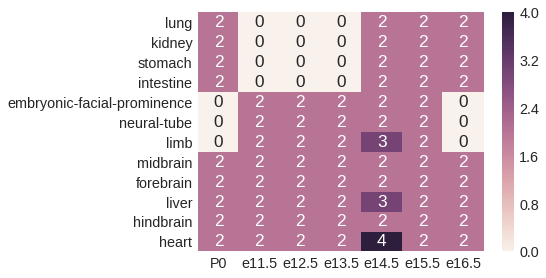

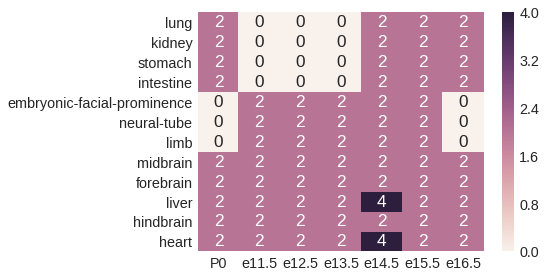

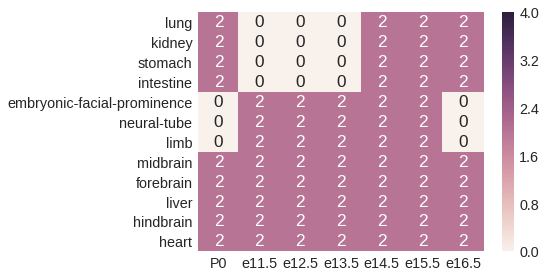

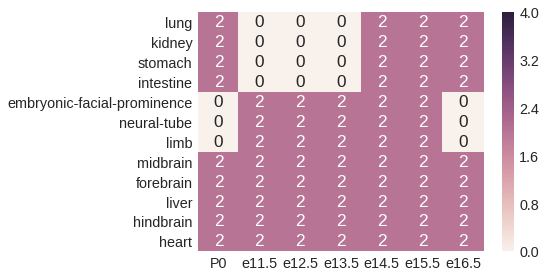

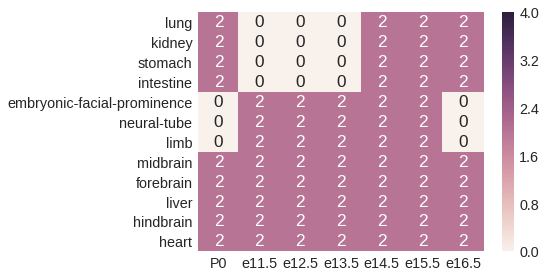

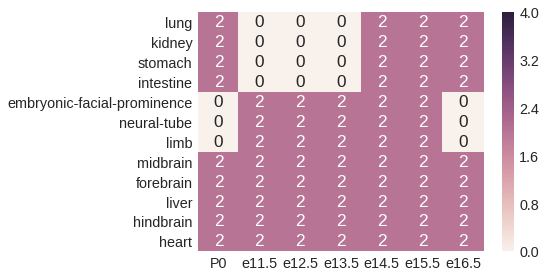

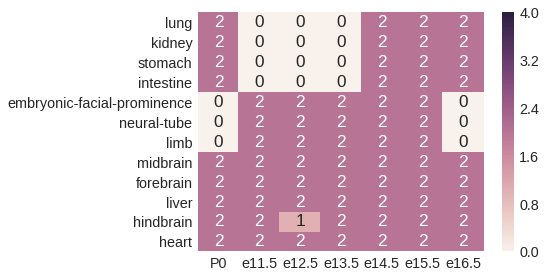

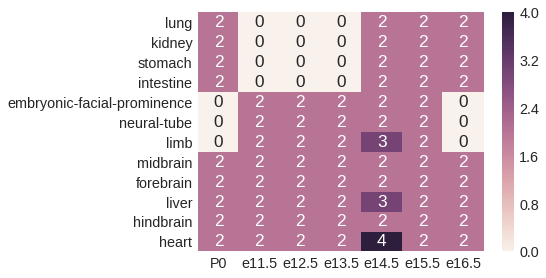

In [82]:
f_acc_dic = {}
meta_dic = {}
count = 0

for indx,exp in enumerate(targets):
    meta_dic = {}
    plt.figure(indx)
    data_df = pd.DataFrame(0,index=data_df.index, columns=data_df.columns)
    mark = exp.split('-')[0]
    if mark in ['H3K27me3','H3K9me3','H3K9ac','H3K4me1','H3K4me2','H3K4me3','H3K36me3','H3K27ac']:
        #os.system('mkdir /home/shared/Data/encode/mouse/{}_rep_peaks'.format(exp.split('-')[0]))
        count = 0
        for r in df.iterrows():
            term = '-'.join(r[1]['Biosample term name'].split(' '))
            age = 'e{}'.format(r[1]['Biosample Age'].split(' ')[0])
            if age == "e0":
                age = 'P0'
            rep = r[1]['Biological replicate(s)']
            f_acc = r[1]['File accession']
            target = r[1]['Experiment target']
            url = r[1]['File download URL']
            if age not in ['e10.5','e8','eunknown']:
                if term not in ['brain','brown-adipose-tissue']:
                     if target == exp:
                        
                        if rep == '1, 2':
                            if r[1]['Audit ERROR'] != "extremely low read depth":
                                if r[1]['Output type'] == 'replicated peaks':
                                    if term not in meta_dic.keys():
                                        meta_dic[term] = []
                                        meta_dic[term].append(age)
                                        f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                    else:
                                        if age not in meta_dic[term]:
                                            meta_dic[term].append(age)
                                            f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                    count += 1
                                    data_df.ix[term,age] += 1
        print(mark, count)
        #avail_data_df = get_data_filled(meta_dic,data_df)
        sb.heatmap(data_df,annot=True,fmt="d",vmax=4,vmin=0)
        
                                    #os.system('wget -P /home/shared/Data/encode/mouse/{}_rep_peaks/ {}'.format(mark,url))
                                    #os.system('mv /home/shared/Data/encode/mouse/{}_rep_peaks/{}.bed.gz /home/shared/Data/encode/mouse/{}_rep_peaks/{}_{}_{}_{}.bed.gz'.format(mark,f_acc,mark,term,age,target,f_acc))
                                    



    

In [64]:
meta_dic

{'embryonic-facial-prominence': ['e13.5', 'e11.5', 'e12.5', 'e15.5', 'e14.5'],
 'forebrain': ['e12.5', 'e15.5', 'P0', 'e11.5', 'e14.5', 'e16.5', 'e13.5'],
 'heart': ['e12.5', 'e15.5', 'e13.5', 'e11.5', 'P0', 'e14.5', 'e16.5'],
 'hindbrain': ['e12.5', 'e11.5', 'e14.5', 'e13.5', 'e15.5', 'e16.5', 'P0'],
 'intestine': ['e14.5', 'e16.5', 'P0', 'e15.5'],
 'kidney': ['e16.5', 'e15.5', 'e14.5', 'P0'],
 'limb': ['e12.5', 'e13.5', 'e11.5', 'e14.5', 'e15.5'],
 'liver': ['e13.5', 'e16.5', 'e14.5', 'P0', 'e11.5', 'e12.5', 'e15.5'],
 'lung': ['e16.5', 'e15.5', 'P0', 'e14.5'],
 'midbrain': ['e14.5', 'e12.5', 'P0', 'e16.5', 'e15.5', 'e13.5', 'e11.5'],
 'neural-tube': ['e12.5', 'e14.5', 'e15.5', 'e11.5', 'e13.5'],
 'stomach': ['e14.5', 'P0', 'e15.5', 'e16.5']}

#### plot chIP data availability

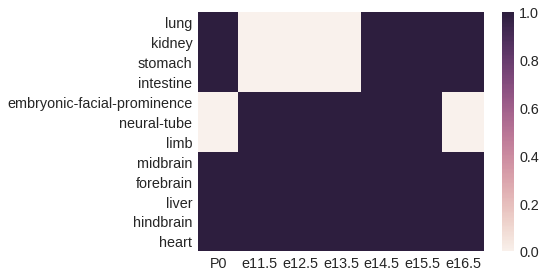

In [76]:
def get_data_filled(dic,zdf):
    for i in dic.keys():
        for t in dic[i]:
            zdf.ix[i,t] = 1
    return zdf

data_df = pd.DataFrame(0,index=data_df.index, columns=data_df.columns)
avail_data_df = get_data_filled(meta_dic,data_df)
sb.heatmap(avail_data_df)

#### plot chromHMM data availability

In [65]:
data_analysis = {'embryonic-facial-prominence': ['e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'forebrain': ['e12.5', 'e11.5', 'e15.5', 'e13.5', 'e14.5', 'e16.5', 'P0'],
 'heart': ['e11.5', 'e16.5', 'e13.5', 'e15.5', 'P0', 'e12.5', 'e14.5'],
 'hindbrain': ['e14.5', 'e11.5', 'e15.5', 'e13.5', 'P0', 'e12.5', 'e16.5'],
 'intestine': ['P0', 'e15.5', 'e14.5', 'e16.5'],
 'kidney': ['e16.5', 'e14.5', 'e15.5', 'P0'],
 'limb': ['e12.5', 'e13.5', 'e15.5', 'e14.5', 'e11.5'],
 'liver': ['P0', 'e16.5', 'e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'lung': ['e14.5', 'P0', 'e16.5', 'e15.5'],
 'midbrain': ['e16.5', 'e13.5', 'e14.5', 'e11.5', 'e15.5', 'e12.5', 'P0'],
 'neural-tube': ['e14.5', 'e13.5', 'e11.5', 'e15.5', 'e12.5'],
 'stomach': ['e14.5', 'P0', 'e15.5', 'e16.5']}

In [66]:
time_pt = ['P0','e11.5','e12.5','e13.5','e14.5','e15.5','e16.5']
data_df = pd.DataFrame(0,index=data_analysis.keys(),columns=time_pt)

In [67]:
for i in data_analysis.keys():
    for t in data_analysis[i]:
        data_df.ix[i,t] = 1

In [68]:
data_df['sum'] = list(data_df.sum(axis=1))

In [69]:
data_df.sort_values(by='sum',inplace=True)

In [70]:
del(data_df['sum'])

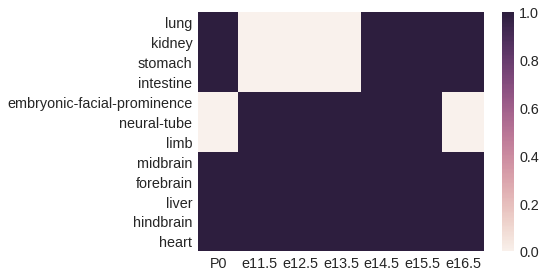

In [71]:
sb.set_context('paper',font_scale=1.8)
sb.heatmap(data_df)

### download bam files

In [5]:
targets = list(set(df['Experiment target']))

In [6]:
def get_file(tup):
    mark,url,acc,name = tup
    os.system('wget -P /home/shared/Data/encode/mouse/{}_bam/ {}'.format(mark,url))
    os.system('mv /home/shared/Data/encode/mouse/{}_bam/{}.bam /home/shared/Data/encode/mouse/{}_bam/{}.bam'.format(mark,acc,mark,name))
    

In [7]:
import multiprocessing as mp
p = mp.Pool(64)

In [ ]:
f_acc_dic = {}
meta_dic = {}
count = 0

for exp in targets:
    mark = exp.split('-')[0]
    if mark in ['H3K27ac']:
        os.system('mkdir /home/shared/Data/encode/mouse/{}_bam'.format(exp.split('-')[0]))
        count = 0
        meta_tups = []
        for r in df.iterrows():
            term = '-'.join(r[1]['Biosample term name'].split(' '))
            age = 'e{}'.format(r[1]['Biosample Age'].split(' ')[0])
            if age == "e0":
                age = 'P0'
            rep = r[1]['Biological replicate(s)']
            f_acc = r[1]['File accession']
            target = r[1]['Experiment target']
            url = r[1]['File download URL']
            if age not in ['e10.5','e8','eunknown']:
                if term not in ['brain','brown-adipose-tissue']:
                     if target == exp:
                        
                        #if rep == '1, 2':
                        if r[1]['Audit ERROR'] != "extremely low read depth":
                            if r[1]['Output type'] == 'alignments':
                                if term not in meta_dic.keys():
                                    meta_dic[term] = []
                                    meta_dic[term].append(age)
                                    f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                else:
                                    if age not in meta_dic[term]:
                                        meta_dic[term].append(age)
                                        f_acc_dic[f_acc] = "{}_{}".format(term,age)
                                    meta_tups.append((mark,url,f_acc,'{}_{}_{}_{}_{}'.format(term,age,rep,target,f_acc)))
        print(mark, len(meta_tups))
        p.map(get_file,meta_tups)



    

H3K27ac 270


### download RNA-seq data

In [84]:
meta = pd.read_csv('/home/shared/Data/encode/mouse/RNA-seq/metadata.tsv',sep='\t')

In [32]:
meta.columns

Index(['File accession', 'File format', 'Output type', 'Experiment accession',
       'Assay', 'Biosample term id', 'Biosample term name', 'Biosample type',
       'Biosample life stage', 'Biosample sex', 'Biosample Age',
       'Biosample organism', 'Biosample treatments',
       'Biosample subcellular fraction term name', 'Biosample phase',
       'Biosample synchronization stage', 'Experiment target',
       'Antibody accession', 'Library made from', 'Library depleted in',
       'Library extraction method', 'Library lysis method',
       'Library crosslinking method', 'Library strand specific',
       'Experiment date released', 'Project', 'RBNS protein concentration',
       'Library fragmentation method', 'Library size range',
       'Biological replicate(s)', 'Technical replicate', 'Read length',
       'Mapped read length', 'Run type', 'Paired end', 'Paired with',
       'Derived from', 'Size', 'Lab', 'md5sum', 'dbxrefs', 'File download URL',
       'Assembly', 'Platform', 'Con

In [42]:
meta[['File accession','Biosample term name','Biosample Age','Biological replicate(s)','Technical replicate','File format','Output type','Assay','Biosample term id','Experiment accession']]

,File accession,Biosample term name,Biosample Age,Biological replicate(s),Technical replicate,File format,Output type,Assay,Biosample term id,Experiment accession
0,ENCFF023JWC,lung,10 week,1,NaN,bam,alignments,RNA-seq,UBERON:0002048,ENCSR870AQU
1,ENCFF011OJV,lung,10 week,1,NaN,bam,transcriptome alignments,RNA-seq,UBERON:0002048,ENCSR870AQU
2,ENCFF570TXY,lung,10 week,1,NaN,bam,alignments,RNA-seq,UBERON:0002048,ENCSR870AQU
3,ENCFF311GFM,lung,10 week,1,NaN,bam,transcriptome alignments,RNA-seq,UBERON:0002048,ENCSR870AQU
4,ENCFF253VRX,lung,10 week,1,NaN,tsv,transcript quantifications,RNA-seq,UBERON:0002048,ENCSR870AQU
5,ENCFF203RCU,lung,10 week,1,NaN,tsv,gene quantifications,RNA-seq,UBERON:0002048,ENCSR870AQU
6,ENCFF115BZB,lung,10 week,1,NaN,tsv,gene quantifications,RNA-seq,UBERON:0002048,ENCSR870AQU
7,ENCFF451PNG,lung,10 week,1,NaN,tsv,transcript quantifications,RNA-seq,UBERON:0002048,ENCSR870AQU
8,ENCFF208XHD,adrenal gland,10 week,1,NaN,bam,alignments,RNA-seq,UBERON:0002369,ENCSR713OCQ
9,ENCFF534NTW,adrenal gland,10 week,1,NaN,bam,transcriptome alignments,RNA-seq,UBERON:0002369,ENCSR713OCQ


{'midbrain': ['P0', 'e11.5', 'e13.5', 'e14.5', 'e15.5', 'e12.5', 'e16.5'], 'liver': ['e14.5', 'e16.5', 'e13.5', 'e15.5', 'e12.5', 'e11.5', 'P0'], 'neural-tube': ['e11.5', 'P0', 'e14.5', 'e12.5', 'e13.5', 'e15.5'], 'embryonic-facial-prominence': ['e11.5', 'e13.5', 'e14.5', 'e15.5', 'e12.5'], 'forebrain': ['P0', 'e16.5', 'e11.5', 'e14.5', 'e15.5', 'e13.5', 'e12.5'], 'lung': ['P0', 'e16.5', 'e14.5', 'e15.5'], 'limb': ['e14.5', 'e13.5', 'e15.5', 'e11.5', 'e12.5'], 'hindbrain': ['P0', 'e14.5', 'e16.5', 'e11.5', 'e12.5', 'e15.5', 'e13.5'], 'heart': ['e14.5', 'e13.5', 'e11.5', 'P0', 'e16.5', 'e15.5', 'e12.5'], 'kidney': ['P0', 'e14.5', 'e15.5', 'e16.5'], 'stomach': ['P0', 'e15.5', 'e16.5', 'e14.5'], 'intestine': ['e14.5', 'e15.5', 'e16.5', 'P0']}


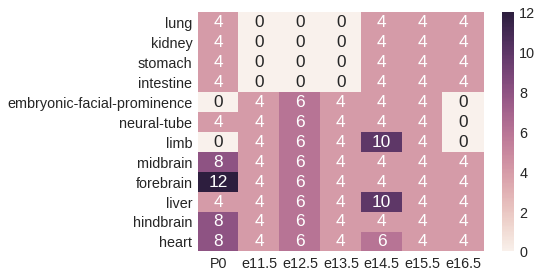

In [101]:
meta_dic = {}
meta_tups = []

data_df = pd.DataFrame(0,index=data_df.index, columns=data_df.columns)

for r in meta.iterrows():
    term = '-'.join(r[1]['Biosample term name'].split(' '))
    age = 'e{}'.format(r[1]['Biosample Age'].split(' ')[0])
    sex = r[1]['Biosample sex']
    if age == "e0":
        age = 'P0'
    rep = r[1]['Biological replicate(s)']
    f_acc = r[1]['File accession']
    url = r[1]['File download URL']
    target = r[1]['Assay']
    if term in data_df.index:
        if target == 'RNA-seq':
            if age not in ['e10.5','e10','e8','e14','e18','eunknown']:
                if term not in ['brain','brown-adipose-tissue']:
                    if r[1]['Output type'] == 'gene quantifications':
                        if term not in meta_dic.keys():
                            meta_dic[term] = []
                            meta_dic[term].append(age)
                            f_acc_dic[f_acc] = "{}_{}".format(term,age)
                        else:
                            if age not in meta_dic[term]:
                                meta_dic[term].append(age)
                                f_acc_dic[f_acc] = "{}_{}".format(term,age)
                        #print(term,age)
                        #break
                        data_df.ix[term,age] += 1
#                     #meta_tups.append(
#                         (
#                             target,
#                             url,
#                             f_acc,
#                             '{}_{}_{}_{}_{}_{}'.format(term,age,sex,rep,target,f_acc)
#                         )
#                     )

sb.heatmap(data_df,annot=True,fmt='d')
print(meta_dic)

In [ ]:
def get_file(tup):
    mark,url,acc,name = tup
    os.system('wget -P /home/shared/Data/encode/mouse/RNA-seq/gene_quantification/ {}'.format(url))
    os.system('mv /home/shared/Data/encode/mouse/RNA-seq/gene_quantification/{}.tsv /home/shared/Data/encode/mouse/RNA-seq/gene_quantification/{}.tsv'.format(acc,name))

import multiprocessing as mp
p = mp.Pool(64)    
out = p.map(get_file,meta_tups)

In [142]:
gq_files = glob.glob('/home/shared/Data/encode/mouse/RNA-seq/gene_quantification/*')

In [159]:
def get_filtered_genes(df,name):
    gene_list = list(df['gene_id'])
    sel_g = ['ENS' in c for c in gene_list]
    sel_df = pd.DataFrame(df[sel_g][['gene_id','TPM']])
    sel_df.columns = ['gene_id',name]
    return sel_df
gq_mat = pd.DataFrame()
for f in gq_files:
    gq_df = pd.read_csv(f,sep='\t')
    f_name = f.split('/')[-1].split('.tsv')[0]
    gq_df_sel = get_filtered_genes(gq_df,f_name)
    gq_df_sel.set_index('gene_id',inplace=True)
    if gq_mat.shape == (0,0):
        gq_mat = gq_df_sel
    else:
        gq_mat = gq_mat.join(gq_df_sel)
        

In [162]:
gq_mat.isnull().values.any()

False

In [161]:
gq_mat.fillna(value=0,inplace=True)

In [163]:
gq_mat.to_csv('/home/shared/Data/encode/mouse/RNA-seq/Expression_matrix.txt',sep='\t')

In [38]:
gq_mat = pd.read_csv('/home/shared/Data/encode/mouse/Expression_matrix.txt',sep='\t')

In [40]:
gq_mat.set_index('gene_id',inplace=True)

In [43]:
gq_mat_log2TPM = np.log2(gq_mat+1)

In [44]:
gq_mat_log2TPM.to_csv('/home/shared/Data/encode/mouse/gene_expression_log2TPM_signal_matrix.txt',sep='\t')

In [232]:
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

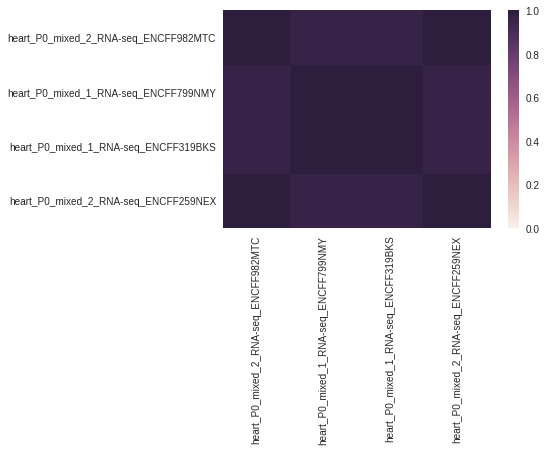

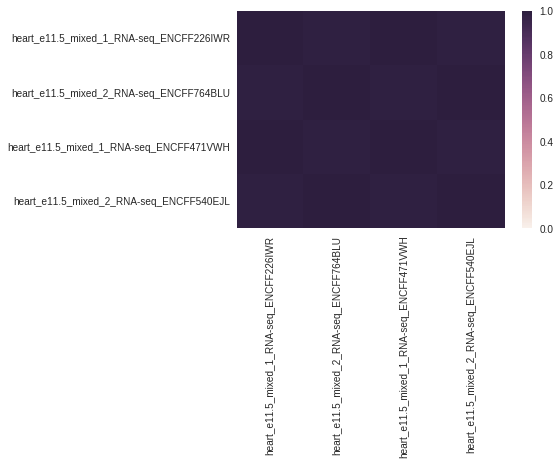

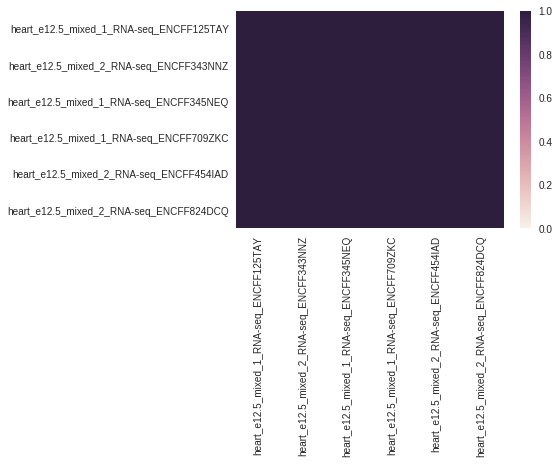

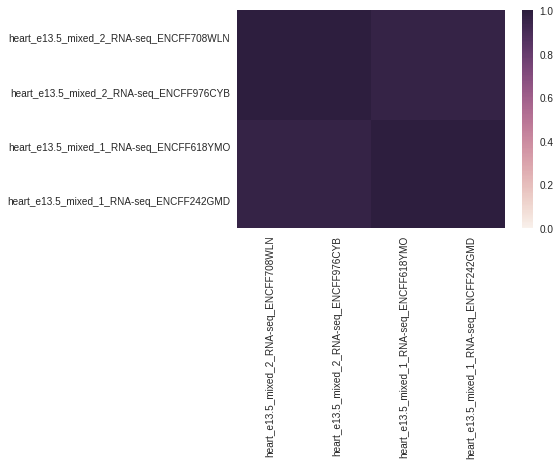

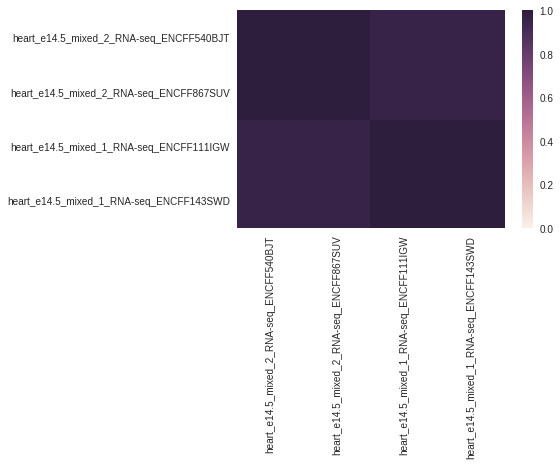

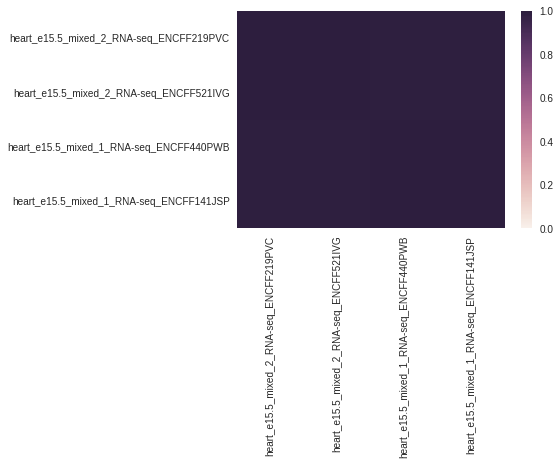

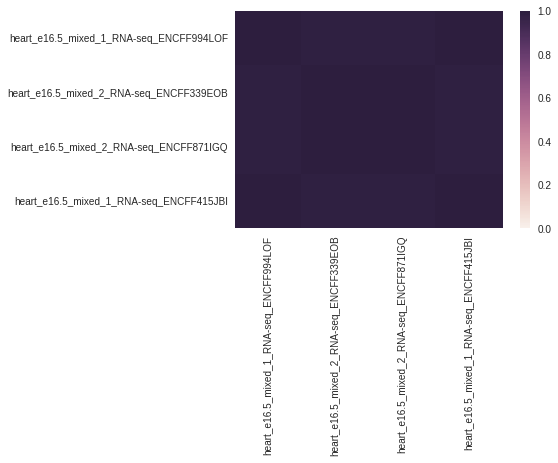

In [231]:
stages = ['P0','e11.5','e12.5','e13.5','e14.5','e15.5','e16.5']
heart_to_remove = ['ENCFF662WLV','ENCFF705YYN','unknown']
for i,s in enumerate(stages):
    plt.figure(i)
    heart = gq_mat.ix[:,['heart_{}'.format(s) in c for c in gq_mat.columns]]
    heart = heart.ix[:,[all(sb not in c for sb in heart_to_remove) for c in heart.columns]]
    sb.heatmap(heart.corr(),vmin=0,vmax=1)

### get TPM (transcript per millions) for each enhancers

##### To find total number of reads in bam

In [41]:

import subprocess

output = subprocess.check_output("samtools view -c /home/shared/Data/encode/mouse/H3K36me3_bam/hindbrain_e13.5_1_H3K36me3-mouse_ENCFF669UYV.bam",shell=True)
print(int(output.strip()))

56418369


##### Get TPMs

In [2]:
df = pd.read_csv('/home/shared/Data/encode/mouse/ChIP/metadata.tsv',sep='\t')

In [3]:
files = glob.glob('/home/shared/Data/encode/mouse/ChIP/bam/H3K27ac_bam/*')

In [4]:
def get_reads_regions(f):
    name = f.split('/')[-1].split('.bam')[0]
    n_arr = name.split('_')
    tissue = n_arr[0]
    age = n_arr[1]
    sex = n_arr[2]
    rep = n_arr[3]
    assay = n_arr[4]
    acc = n_arr[5]
    subprocess.call('bedtools coverage -a /home/vamin/projects/epee/peak_overlapped_pc_tss_subtracted_enh_mouse_pc_tss_subtracted.bed -b {} > /home/shared/Data/encode/mouse/ChIP/{}_H3K27ac_reads.bed'.format(f,name),shell=True)
    

In [ ]:
for f in files:
    get_reads_regions(f)

In [14]:
coverage_files = glob.glob('/home/shared/Data/encode/mouse/ChIP/*_reads.bed')

In [16]:
coverage_files[0]

'/home/shared/Data/encode/mouse/ChIP/limb_e14.5_mixed_1_H3K27ac-mouse_ENCFF219IYF_H3K27ac_reads.bed'

In [15]:
len(coverage_files)

270

In [22]:
import numpy as np
enh_signal_df = pd.DataFrame()
for f in coverage_files:
    name = f.split('/')[-1].split('_H3K27ac_reads.bed')[0]
    counts_df = pd.read_csv(f,sep='\t',header=None)
    tpms = (counts_df[3]/counts_df[5])*(1/sum(counts_df[3]/counts_df[5]))*1e6
    signal = np.log2(tpms+1)
    if enh_signal_df.shape == (0,0):
        enh_signal_df = counts_df.ix[:,[0,1,2]]
        enh_signal_df.columns = ['chr','start','stop']
        enh_signal_df[name] = signal
    else:
        enh_signal_df[name] = signal
    

In [26]:
enh_signal_df.to_csv('/home/shared/Data/encode/mouse/enh_H3K27ac_log2TPM_signal_matrix.txt',sep='\t')

In [50]:
import seaborn as sns
%matplotlib inline

In [57]:
import numpy as np

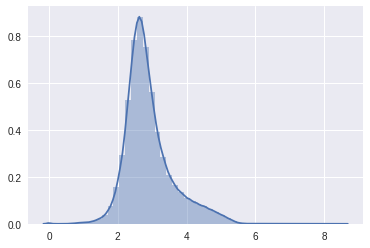

In [61]:
sns.distplot(np.log2(tpms+1))

In [65]:
data_analysis = {'embryonic-facial-prominence': ['e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'forebrain': ['e12.5', 'e11.5', 'e15.5', 'e13.5', 'e14.5', 'e16.5', 'P0'],
 'heart': ['e11.5', 'e16.5', 'e13.5', 'e15.5', 'P0', 'e12.5', 'e14.5'],
 'hindbrain': ['e14.5', 'e11.5', 'e15.5', 'e13.5', 'P0', 'e12.5', 'e16.5'],
 'intestine': ['P0', 'e15.5', 'e14.5', 'e16.5'],
 'kidney': ['e16.5', 'e14.5', 'e15.5', 'P0'],
 'limb': ['e12.5', 'e13.5', 'e15.5', 'e14.5', 'e11.5'],
 'liver': ['P0', 'e16.5', 'e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'lung': ['e14.5', 'P0', 'e16.5', 'e15.5'],
 'midbrain': ['e16.5', 'e13.5', 'e14.5', 'e11.5', 'e15.5', 'e12.5', 'P0'],
 'neural-tube': ['e14.5', 'e13.5', 'e11.5', 'e15.5', 'e12.5'],
 'stomach': ['e14.5', 'P0', 'e15.5', 'e16.5']}

In [66]:
time_pt = ['P0','e11.5','e12.5','e13.5','e14.5','e15.5','e16.5']
data_df = pd.DataFrame(0,index=data_analysis.keys(),columns=time_pt)

In [72]:
def get_data_filled(dic,zdf):
    for i in dic.keys():
        for t in dic[i]:
            zdf.ix[i,t] = 1
    return zdf

In [67]:
for i in data_analysis.keys():
    for t in data_analysis[i]:
        data_df.ix[i,t] = 1

In [68]:
data_df['sum'] = list(data_df.sum(axis=1))

In [69]:
data_df.sort_values(by='sum',inplace=True)

In [70]:
del(data_df['sum'])

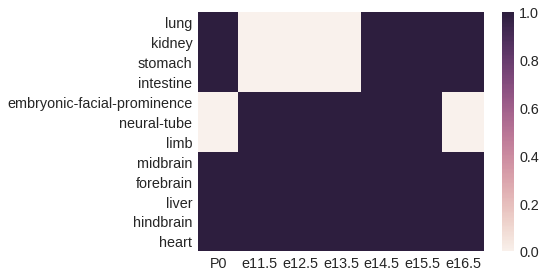

In [71]:
sb.set_context('paper',font_scale=1.8)
sb.heatmap(data_df)

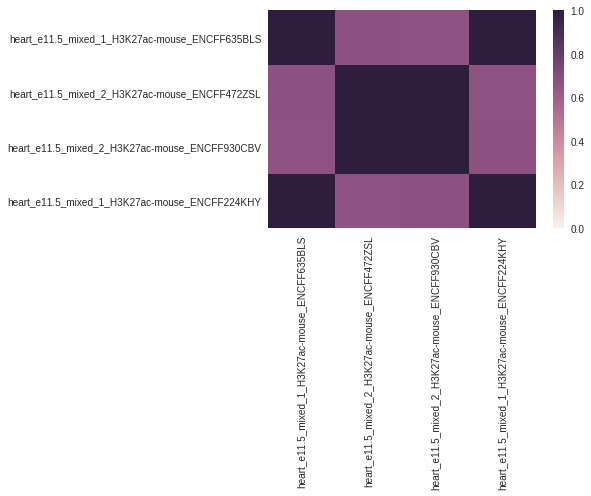

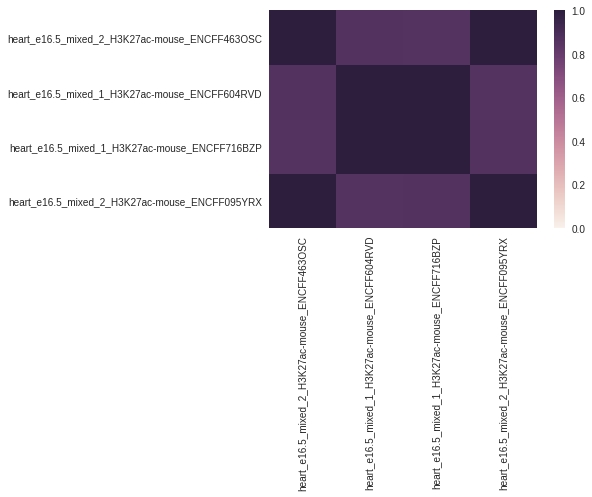

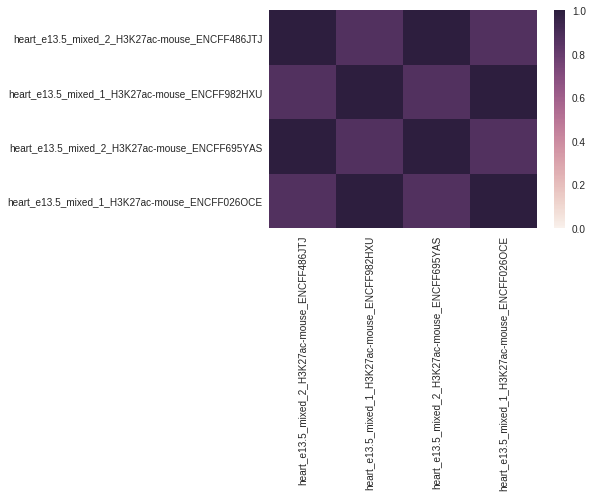

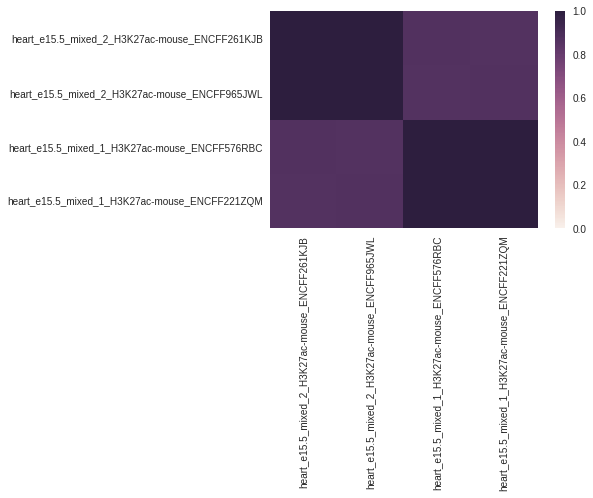

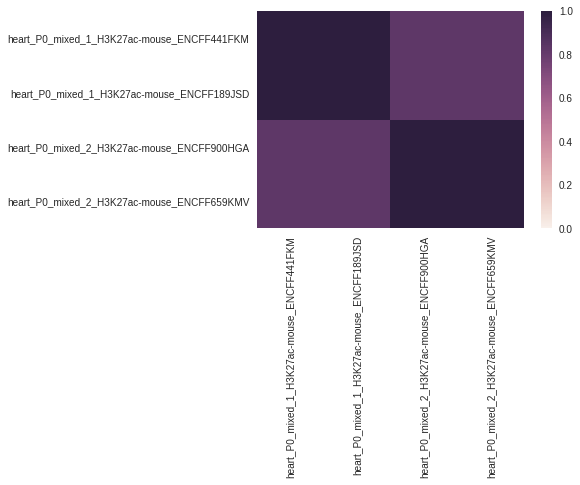

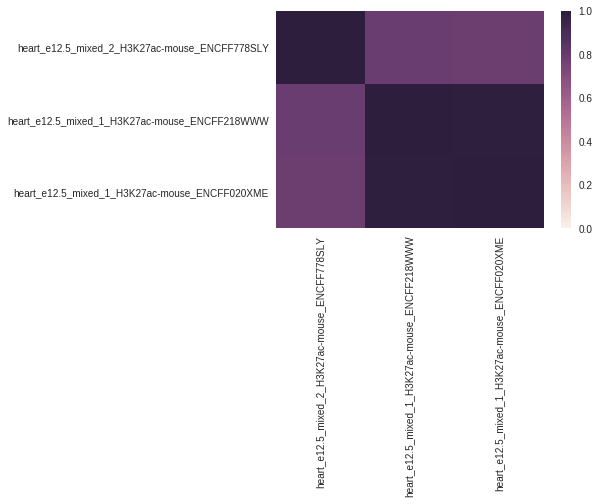

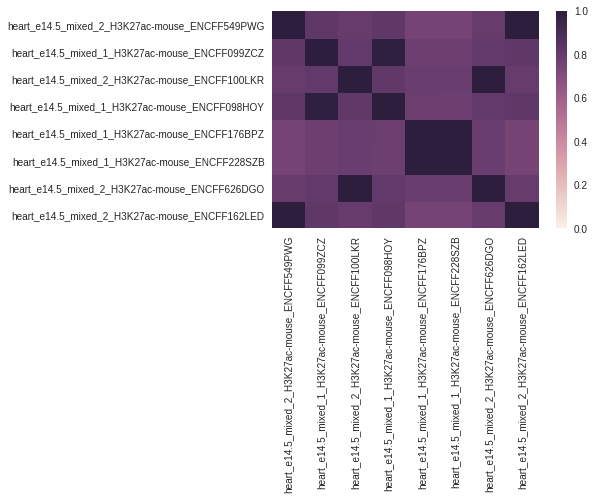

In [36]:
data_to_remove = ['ENCFF001KGS','ENCFF001KGT']
for indx,val in enumerate(data_analysis['heart']):
    temp = enh_signal_df.ix[:,['heart_{}'.format(val) in c for c in enh_signal_df.columns]]
    tempf = temp.ix[:,[all(sb not in c for sb in data_to_remove) for c in temp.columns]]
    plt.figure(indx)
    sb.heatmap(tempf.corr(),vmin=0,vmax=1)

In [ ]:
data_to_remove = ['ENCFF001KGS','ENCFF001KGT']